This examples shows how to compute SRC indices confidence bounds with bootstrap. First compute SRC indices and draw them.
Then compute confidence bounds and draw them.

In [1]:
import openturns as ot
import openturns.viewer as otv
from math import sqrt
import pylab as pl

We define the function g.

In [2]:
def functionCrue8vars(X):
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv) / L
    H = (Q / (Ks * B * sqrt(alpha))) ** (3.0 / 5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]


g = ot.PythonFunction(8, 1, functionCrue8vars)
g.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])

Hd = 8.0
Zb = 55.5
L = 5000.0
B = 300.0
X = [Hd, Zb, L, B]
g_parametric = ot.ParametricFunction(g, [4, 5, 6, 7], X)

Then we define the random vector. 

In [3]:
Q = ot.Gumbel(558.0, 1013.0)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

X = ot.ComposedDistribution([Q, Ks, Zv, Zm])

We produce a pair of input and output sample.

In [4]:
sampleSize = 100
sampleX = X.getSample(sampleSize)
sampleY = g_parametric(sampleX)

SRCindices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
print(SRCindices)

[0.378122,0.159565,0.180492,0.00565251]


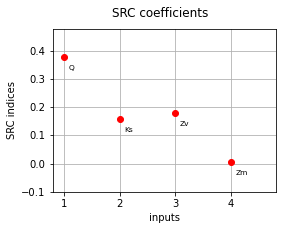

In [5]:
input_names = g_parametric.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    SRCindices, input_names, "SRC coefficients"
)
graph.setYTitle("SRC indices")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.1 + max(SRCindices))

In [6]:
# Create a sample with (X,Y)
dim = sampleX.getDimension()
fullSample = ot.Sample(sampleSize, dim + 1)
fullSample[:, 0:dim] = sampleX
fullSample[:, dim] = sampleY

# Create SRC bootstrap sample
bootstrapSize = 100
SRCBS = ot.Sample(bootstrapSize, dim)
bootstrap = ot.BootstrapExperiment(fullSample)
for i in range(bootstrapSize):
    fullSampleBS = bootstrap.generate()
    sampleXBS = fullSampleBS[:, 0:dim]
    sampleYBS = fullSampleBS[:, dim]
    SRCBS[i, :] = ot.CorrelationAnalysis.SRC(sampleXBS, sampleYBS)

# Compute bootstrap quantiles
alpha = 0.05
SRClow = SRCBS.computeQuantilePerComponent(alpha / 2)
SRCup = SRCBS.computeQuantilePerComponent(1 - alpha / 2)
SRCBounds = ot.Interval(SRClow, SRCup)
print(SRCBounds)

[0.279526, 0.471558]
[0.0933866, 0.292377]
[0.117489, 0.27868]
[0.00126018, 0.0141868]


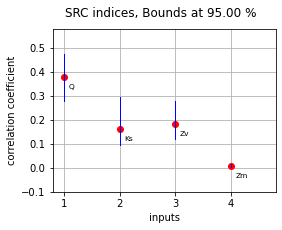

In [7]:
def plotSRCIndicesWithConfidenceIntervals(SRCindices, input_names, alpha, SRCBounds):
    """
    Plot SRC indices with confidence bounds of level 1 - alpha
    
    Parameters
    ----------
    SRCindices : ot.Point(dimension)
        The SRC indices.
    input_names : list(str)
        The names of the input variables.
    alpha : float, in [0, 1]
        The complementary confidence level.
    SRCBounds : ot.Interval(dimension)
        The lower and upper bounds of the SRC indices
    
    Returns
    -------
    graph : ot.Graph
        The SRC indices with lower and upper 1-alpha confidence intervals.
    """
    dim = SRCindices.getDimension()
    lowerBounds = SRCBounds.getLowerBound()
    upperBounds = SRCBounds.getUpperBound()
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        SRCindices, input_names, "SRC coefficients"
    )
    title = "SRC indices, Bounds at %.2f %%" % ((1 - alpha) * 100)

    graph.setTitle(title)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        graph.add(curve)
    return graph


graph = plotSRCIndicesWithConfidenceIntervals(SRCindices, input_names, alpha, SRCBounds)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top = 0.2 + max(SRCindices))